In [1]:
using Plots
using Printf
using Statistics

# The default format SVG creates figures of size 9600x6400
gr(fmt="png")
nothing

In [2]:
using Revise

In [3]:
module CliffWalking

using ReinforcementLearningSutton.Commons: Point
using ReinforcementLearningSutton.GridWorld: GameGridWorldStatic, StateGridWorldStatic, ActionGridWorldStatic, restart, state, state_set, ncols, nrows
import ReinforcementLearningSutton.GridWorld: update

struct Cliff
    track::Array{Bool, 2}
    penalty::Int
end

function update(game::GameGridWorldStatic{Cliff}, action::ActionGridWorldStatic)::Int
    cliff = game.ruleset
    s0 = state(game)
    
    pos_x = max(1, min(s0.pos.x + action.move.x, ncols(game)))
    pos_y = max(1, min(s0.pos.y + action.move.y, nrows(game)))
    penalty = ifelse(cliff.track[pos_y, pos_x], cliff.penalty, -1)
    
    if penalty < -1
        restart(game)
    else
        s = StateGridWorldStatic(nrows(game), ncols(game), Point(pos_x, pos_y))
        state_set(game, s)
    end
    penalty
end

end

Main.CliffWalking

In [4]:
using ReinforcementLearningSutton.Commons: LearningSarsa, LearningQ, PlayerεGreedy, Point, play_game
using ReinforcementLearningSutton.GridWorld: GameGridWorldStaticBase, GameGridWorldStatic

In [5]:
nrows = 4
ncols = 12
pos_start = Point(1, nrows)
pos_goal = Point(ncols, nrows)

allowed_movements = "cross"

cliff_track = zeros(Bool, nrows, ncols)
cliff_track[nrows, 2:(ncols-1)] .= true
cliff = CliffWalking.Cliff(cliff_track, -100)

Main.CliffWalking.Cliff(Bool[0 0 … 0 0; 0 0 … 0 0; 0 0 … 0 0; 0 1 … 1 0], -100)

In [6]:
ε = 0.1
α = 0.5
γ = 1.0

max_nrounds = 1000
ngames = 100000

game0 = GameGridWorldStaticBase(nrows, ncols, pos_start, pos_goal, allowed_movements)
game = GameGridWorldStatic(game0, cliff)

GameGridWorldStatic{Main.CliffWalking.Cliff}(GameGridWorldStaticBase(4, 12, Base.RefValue{ReinforcementLearningSutton.GridWorld.StateGridWorldStatic}(State(pos=(1, 4))), State(pos=(1, 4)), State(pos=(12, 4)), "cross", (nothing,)), Main.CliffWalking.Cliff(Bool[0 0 … 0 0; 0 0 … 0 0; 0 0 … 0 0; 0 1 … 1 0], -100))

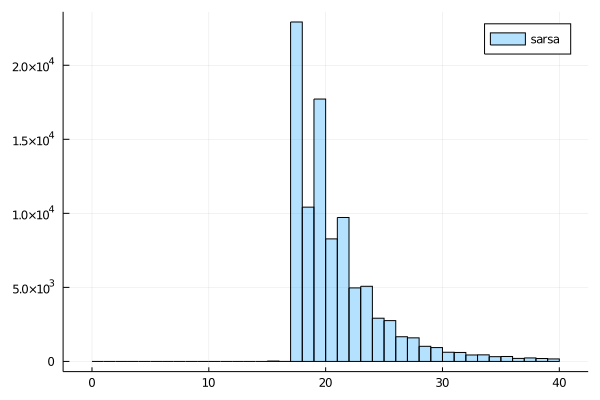

In [7]:
player = PlayerεGreedy(game, ε)
learning = LearningSarsa(player, α, γ)

results_sarsa = -[play_game(game, player, max_nrounds, learning) for _ in 1:ngames]

histogram(results_sarsa, bins=0:1:40, fillalpha=0.3, label=reshape(["sarsa"], 1, :))

In [8]:
mean(results_sarsa)

26.45764

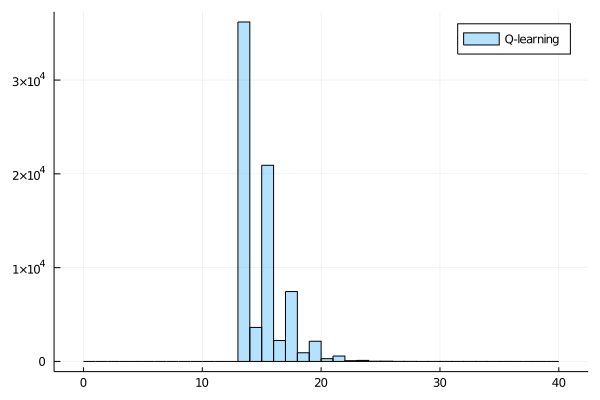

In [9]:
player = PlayerεGreedy(game, ε)
learning = LearningQ(player, α, γ)

results_q = -[play_game(game, player, max_nrounds, learning) for _ in 1:ngames]

histogram(results_q, bins=0:1:40, fillalpha=0.3, label=reshape(["Q-learning"], 1, :))

In [10]:
mean(results_q)

50.61999